In [1]:
import os
import numpy as np
import cv2 as cv
import numpy as np
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [25]:
#Don't forget add "/" to the end of the path
data_dir_path = "./face_nogi/"
tmp = os.listdir(data_dir_path)
dir_list = sorted([x for x in tmp if os.path.isdir(data_dir_path+x)])

face_data=[]
for dir_name in dir_list:
    file_list = os.listdir(data_dir_path+dir_name)
    for file_name in file_list:
        if file_name.endswith(('jpeg','jpg','png','JPEG','JPG','PNG')):
            image_path=str(data_dir_path)+str(dir_name)+'/'+str(file_name)
            image = cv.imread(image_path)
            image = cv.resize(image, (100, 100))
            image = image.transpose(2,0,1)
            image = image/255.
            face_data.append(image)

face_class=[]
count=0
for dir_name in dir_list:
    file_list = os.listdir(data_dir_path+dir_name)
    for file_name in file_list:
        if file_name.endswith(('jpeg','jpg','png','JPEG','JPG','PNG')):
            face_class.append(count)
    count+=1

face_arr=np.array(face_data)
np.save('face_data.npy',face_arr)
target_arr=np.array(face_class)
np.save('face_target.npy',target_arr)
    
X_test=np.array(face_data)
Y_target=np.array(face_class)
a_train, a_test, b_train, b_test = train_test_split(X_test, Y_target, test_size=0)
class_num = Y_target.max() + 1

In [26]:
model = Sequential()
# 96 filters (96 features), 3 * 3 filter. Input data is 100*100 image 3 colors(RGB)
# padding options are 'same' and 'valid'. http://ni4muraano.hatenablog.com/entry/2017/02/02/195505

model.add(Conv2D(96, (3, 3), padding='same', input_shape=(3, 100, 100)))

# Activation function. You can use 'relu' or 'sigmoid'
model.add(Activation("relu"))

# max pool with 2*2 filters
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 0.25 Dropout rate. You can specify floating point number from 0 to 1.
# https://elix-tech.github.io/ja/2016/06/02/kaggle-facial-keypoints-ja.html
model.add(Dropout(0.25))

# Convert to 1 dimension.
model.add(Flatten())

# The number of neuron in the Full connected layer
model.add(Dense(200))

#model.add(Activation("relu"))
#model.add(Dropout(0.2))

# specify the same value with the number of the features
model.add(Dense(class_num, activation='softmax'))


#init_learning_rate = 1e-2
#opt = SGD(lr=init_learning_rate, decay=0.0, momentum=0.9, nesterov=False)
#opt = Adam(lr=0.0001)

# model.compile is for specifying the learning method
# You can specify optimizer SGD, Adadelta, Adamax, Adam, Adagrad,  RMSprop or Nadam
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=["accuracy"])

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')
#lrs = LearningRateScheduler(0.01)

# validation_split splits data into training and validation.
# acc is validation using training data.
# val_acc is validation using validation data.
hist = model.fit(a_train, b_train, batch_size=25, epochs=20, validation_split=0.1, verbose=1)

Train on 859 samples, validate on 96 samples
Epoch 1/20
859/859 [==============================] - 3s 4ms/step - loss: 2.5026 - acc: 0.4075 - val_loss: 1.0572 - val_acc: 0.5833

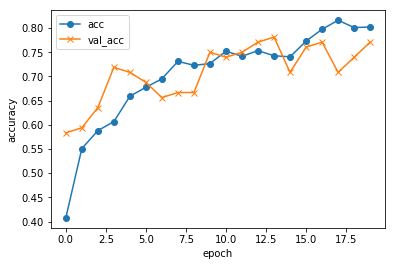

In [27]:
# plot acc and val_acc
plt.plot(hist.history["acc"], label="acc", ls="-", marker="o")
plt.plot(hist.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

# save learning model
model.save('face_model.h5')

#score=model.evaluate(a_test, b_test, verbose=0)
#print(score[1])

In [31]:
tmp = os.listdir(data_dir_path)
dir_list = sorted([x for x in tmp if os.path.isdir(data_dir_path+x)])
dir_num = len(tmp)

model = load_model('face_model.h5')

image = cv.imread('./akimoto.jpg')
image = cv.resize(image, (100, 100))
image = image.transpose(2,0,1)
image = image/255.
image=image.reshape(1,3,100,100)

dir_label=int(model.predict_classes(image))

print(dir_list[int(dir_label)])

# similarity
pred = model.predict(image)[0]
top = 3
top_indices = pred.argsort()[-top:][::-1]
for i in top_indices:
    print(dir_list[i] + ' : ' + str(round(pred[i]*100,2)) + '%')

Manatsu_Akimoto
Manatsu_Akimoto : 62.32%
Erika_Ikuta : 28.65%
Nanase_Nishino : 8.85%
